In [18]:
import os
import json
import math
from collections import Counter

def compute_entropy(action_list):
    counts = Counter(str(a) for a in action_list)
    total = sum(counts.values())
    return -sum((c / total) * math.log(c / total, 2) for c in counts.values() if c > 0)

def detect_coordination_conflicts(observations, actions):
    conflict_count = 0
    for t in range(1, len(observations)):
        pos0 = tuple(observations[t]["players"][0]["position"])
        pos1 = tuple(observations[t]["players"][1]["position"])
        act0 = actions[t][0]
        act1 = actions[t][1]

        both_interact = (
            act0 == "INTERACT" or (isinstance(act0, list) and "INTERACT" in act0)
        ) and (
            act1 == "INTERACT" or (isinstance(act1, list) and "INTERACT" in act1)
        )

        near_same_tile = abs(pos0[0] - pos1[0]) + abs(pos0[1] - pos1[1]) <= 1

        if both_interact and near_same_tile:
            conflict_count += 1

    return conflict_count

def analyze_overcooked_json(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)

    observations = data['ep_observations'][0]
    actions = data['ep_actions'][0]
    rewards = data['ep_rewards'][0]

    total_reward = sum(rewards)
    episode_length = len(observations)
    soups_delivered = rewards.count(20)
    reward_events = [(i, r) for i, r in enumerate(rewards) if r > 0]

    interact_counts = [0, 0]
    idle_counts = [0, 0]
    action_sequences = [[], []]
    division_of_labor = [0, 0]
    soup_holder_at_reward = [[], []]
    reaction_times = []

    for t, frame_actions in enumerate(actions):
        for i in [0, 1]:
            act = frame_actions[i]
            action_sequences[i].append(act)
            if act == "INTERACT" or (isinstance(act, list) and "INTERACT" in act):
                interact_counts[i] += 1
            elif act == [0, 0]:
                idle_counts[i] += 1

    for t, r in reward_events:
        for dt in range(3):
            check_t = max(t - dt, 0)
            for agent in [0, 1]:
                held = observations[check_t]["players"][agent].get("held_object")
                if held and held.get("name") == "soup":
                    soup_holder_at_reward[agent].append(t)
                    division_of_labor[agent] += 1
                    reaction_times.append(dt)
                    break

    entropies = [compute_entropy(seq) for seq in action_sequences]
    avg_reaction_time = sum(reaction_times) / len(reaction_times) if reaction_times else None
    reward_efficiency = total_reward / episode_length if episode_length else 0
    conflict_count = detect_coordination_conflicts(observations, actions)

    print(f"\n📄 File: {os.path.basename(filepath)}")
    print(f"- Episode Length: {episode_length}")
    print(f"- Total Reward: {total_reward}")
    print(f"- Soups Delivered: {soups_delivered}")
    print(f"- Reward Efficiency: {reward_efficiency:.2f}")
    print(f"- INTERACTs: Agent 0 = {interact_counts[0]}, Agent 1 = {interact_counts[1]}")
    print(f"- Idle Steps: Agent 0 = {idle_counts[0]}, Agent 1 = {idle_counts[1]}")
    print(f"- Action Entropy: Agent 0 = {entropies[0]:.2f}, Agent 1 = {entropies[1]:.2f}")
    print(f"- Deliveries (approx): Agent 0 = {division_of_labor[0]}, Agent 1 = {division_of_labor[1]}")
    print(f"- Coordination Conflict Count: {conflict_count}")
    print(f"- Avg Reaction Time: {avg_reaction_time if avg_reaction_time else 'N/A'}")

    if reward_events:
        print(f"- Reward Events:")
        for t, r in reward_events:
            print(f"  • Step {t}: +{r}")
    else:
        print("- No rewards earned.")
# Correct folder path (change as needed)
folder = "Cramped_room/"

# Run analysis
for filename in os.listdir(folder):
    if filename.endswith(".json"):
        analyze_overcooked_json(os.path.join(folder, filename))



📄 File: Human-aware PPO agent vs Human Keyboard Input 60 sec Cramped Room.json
- Episode Length: 404
- Total Reward: 120
- Soups Delivered: 6
- Reward Efficiency: 0.30
- INTERACTs: Agent 0 = 107, Agent 1 = 34
- Idle Steps: Agent 0 = 28, Agent 1 = 293
- Action Entropy: Agent 0 = 2.49, Agent 1 = 1.47
- Deliveries (approx): Agent 0 = 6, Agent 1 = 12
- Coordination Conflict Count: 5
- Avg Reaction Time: 1.0
- Reward Events:
  • Step 40: +20
  • Step 101: +20
  • Step 153: +20
  • Step 239: +20
  • Step 315: +20
  • Step 373: +20

📄 File: Human-aware PPO agent vs Human-aware PPO agent 60 sec Cramped Room.json
- Episode Length: 404
- Total Reward: 180
- Soups Delivered: 9
- Reward Efficiency: 0.45
- INTERACTs: Agent 0 = 91, Agent 1 = 96
- Idle Steps: Agent 0 = 60, Agent 1 = 72
- Action Entropy: Agent 0 = 2.55, Agent 1 = 2.55
- Deliveries (approx): Agent 0 = 15, Agent 1 = 12
- Coordination Conflict Count: 12
- Avg Reaction Time: 1.0
- Reward Events:
  • Step 38: +20
  • Step 73: +20
  • Step

In [2]:
import os
import json
import re
import numpy as np
import itertools
import sys 

FILENAME_PATTERN = re.compile(
    r"^(?P<agent1>.*?) vs (?P<agent2>.*?) (?P<gamelendetails>\d+ sec .*?)(?P<run_open_space> \() *(?P<run_digits>\d+)(?P<run_close>\)\.json)$"
)

# --- Debugging Flag ---
# Set to True to print details for the first file processed and exit.
DEBUG_SINGLE_FILE_EXTRACTION = False # Set to False for normal run
first_file_processed_for_debug = False
# --- End Debugging Flag ---

def _calculate_euclidean_distance(pos1, pos2):
    """Calculates Euclidean distance between two 2D points."""
    # Check if positions are valid numbers before calculation
    if not (isinstance(pos1[0], (int, float)) and isinstance(pos1[1], (int, float)) and
            isinstance(pos2[0], (int, float)) and isinstance(pos2[1], (int, float))):
        # print(f"  Warning: Non-numeric position found: pos1={pos1}, pos2={pos2}")
        return None # Or handle as appropriate (e.g., skip timestep)
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def _extract_average_distance_from_file(filepath):
    """
    Loads a JSON trajectory file and calculates the average distance
    between the two players over all timesteps, adapting to the observed structure.
    """
    global first_file_processed_for_debug

    # --- Detailed Internal Logging (Uncomment sections below to activate for the file above) ---
    # if DEBUG_SINGLE_FILE_EXTRACTION and not first_file_processed_for_debug:
    #     print(f"\nDEBUG_SINGLE_FILE_EXTRACTION: Attempting to process this file first:")
    #     print(f"  {filepath}")
    #     print(f"  Please manually inspect this file's structure. Key things to check:")
    #     print(f"    1. Top-level key 'ep_observations' (is it a list of lists?).")
    #     print(f"    2. Inside the inner list's first element [0]: key 'players' (list of 2 dicts).")
    #     print(f"    3. Inside each dict in 'players': key 'position'.")
    #     print(f"    4. Value of 'position': a list of two numbers (e.g., [x, y]).")
    #     print(f"  You can also uncomment detailed logs within this function (_extract_average_distance_from_file).")
    #     # To exit after checking one file, uncomment the next line
    #     # sys.exit() 
    # --- End Detailed Internal Logging ---

    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except json.JSONDecodeError:
        print(f"  Error: Could not decode JSON from {filepath}")
        return None
    except FileNotFoundError:
        print(f"  Error: File not found {filepath}")
        return None
    except Exception as e:
        print(f"  Error opening or reading file {filepath}: {e}")
        return None

    # *** CORRECTED STRUCTURE ACCESS ***
    # Check for 'ep_observations' key, and that it's a list
    if 'ep_observations' not in data or not isinstance(data['ep_observations'], list):
        # --- Detailed Internal Logging ---
        # print(f"  DEBUG: 'ep_observations' key missing or not a list in {filepath}. data.keys(): {list(data.keys()) if isinstance(data, dict) else 'Not a dict'}")
        # --- End Detailed Internal Logging ---
        return None
    
    if not data['ep_observations']: # Check if ep_observations is an empty list
        # --- Detailed Internal Logging ---
        # print(f"  DEBUG: 'ep_observations' is an empty list in {filepath}")
        # --- End Detailed Internal Logging ---
        return None

    # --- Detailed Internal Logging ---
    # print(f"  DEBUG: Found 'ep_observations' with {len(data['ep_observations'])} timesteps in {filepath}")
    # --- End Detailed Internal Logging ---

    distances_in_run = []
    valid_positions_count = 0
    timesteps_processed = 0

    # Iterate through the outer list of observations
    for i, obs_list in enumerate(data['ep_observations']):
        timesteps_processed += 1
        
        # Check if the inner list exists and has at least one element (the state dict)
        if not obs_list or not isinstance(obs_list, list) or not isinstance(obs_list[0], dict):
            # if i < 5: print(f"    DEBUG Timestep {i}: Inner observation list is empty or not structured as expected.")
            continue

        state = obs_list[0] # Get the actual state dictionary
        pos0, pos1 = None, None 

        try:
            # --- Detailed Internal Logging for each timestep ---
            # if i < 5: # Log only for the first few timesteps
            #     print(f"    DEBUG Timestep {i}: Raw state object keys: {list(state.keys()) if isinstance(state, dict) else 'Not a dict'}")
            # --- End Detailed Internal Logging ---

            # Access player data via the 'players' list
            players_list = state.get('players')
            
            if players_list and isinstance(players_list, list) and len(players_list) == 2:
                player_0_data = players_list[0]
                player_1_data = players_list[1]

                if player_0_data and isinstance(player_0_data, dict):
                    pos0 = player_0_data.get('position')
                if player_1_data and isinstance(player_1_data, dict):
                    pos1 = player_1_data.get('position')
                
                # --- Detailed Internal Logging for positions ---
                # if i < 5:
                #     print(f"      DEBUG Timestep {i}: Extracted pos0: {repr(pos0)}, pos1: {repr(pos1)}")
                # --- End Detailed Internal Logging ---

                if pos0 and pos1 and isinstance(pos0, list) and len(pos0) == 2 and \
                   isinstance(pos1, list) and len(pos1) == 2:
                    dist = _calculate_euclidean_distance(pos0, pos1)
                    if dist is not None: # Check if calculation was successful
                        distances_in_run.append(dist)
                        valid_positions_count +=1
                    # else:
                        # if i < 5: print(f"      DEBUG Timestep {i}: Position coordinates were not numbers. Pos0: {pos0}, Pos1: {pos1}")
                # else:
                    # if i < 5: print(f"      DEBUG Timestep {i}: pos0 or pos1 missing, not a list, or not length 2.")
            # else:
                # if i < 5: print(f"    DEBUG Timestep {i}: 'players' key missing, not a list, or not length 2.")

        except Exception as e:
            # if i < 5: print(f"    DEBUG Timestep {i}: Error processing state: {e}")
            pass # Ignore errors for individual timesteps to be robust
            
    # --- Detailed Internal Logging for file summary ---
    # print(f"  DEBUG Summary for {filepath}:")
    # print(f"    Total timesteps in ep_observations: {len(data['ep_observations'])}")
    # print(f"    Timesteps processed in loop: {timesteps_processed}")
    # print(f"    Timesteps with valid positions found: {valid_positions_count}")
    # print(f"    Calculated distances: {distances_in_run[:5]}{'...' if len(distances_in_run) > 5 else ''}")
    # --- End Detailed Internal Logging ---

    if DEBUG_SINGLE_FILE_EXTRACTION and not first_file_processed_for_debug:
        print(f"  DEBUG_SINGLE_FILE_EXTRACTION: Finished attempt for {filepath}. Valid positions found: {valid_positions_count} out of {len(data['ep_observations'])} states.")
        first_file_processed_for_debug = True 
        if valid_positions_count == 0 and len(data['ep_observations']) > 0:
             print(f"    >>>>> This file ({filepath}) had states but yielded NO valid distances. Check JSON structure and uncomment detailed logs above. <<<<<")
        print("  Exiting now for focused debugging. To run full analysis, set DEBUG_SINGLE_FILE_EXTRACTION to False.")
        sys.exit()

    return np.mean(distances_in_run) if distances_in_run else None

def get_agent_pair_distances(directory_path, target_agent_pair_tuple, all_agent_names_repr_map):
    if not isinstance(target_agent_pair_tuple, tuple) or len(target_agent_pair_tuple) != 2:
        raise ValueError("target_agent_pair_tuple must be a tuple of two agent names.")
    if target_agent_pair_tuple[0] > target_agent_pair_tuple[1]: 
        raise ValueError("target_agent_pair_tuple must have agent names sorted alphabetically.")

    canonical_target_name = " vs ".join(target_agent_pair_tuple)
    run_distances = {}
    found_any_match_for_this_target_pair = False

    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            match = FILENAME_PATTERN.match(filename)
            if match:
                file_data = match.groupdict()
                agent1_from_filename = file_data['agent1'].strip() 
                agent2_from_filename = file_data['agent2'].strip()
                file_pair_canonical_name_from_file = " vs ".join(sorted([agent1_from_filename, agent2_from_filename]))

                if file_pair_canonical_name_from_file == canonical_target_name:
                    found_any_match_for_this_target_pair = True
                    try:
                        run_num = int(file_data['run_digits'])
                        filepath = os.path.join(directory_path, filename)
                        avg_dist = _extract_average_distance_from_file(filepath)
                        if avg_dist is not None:
                            run_distances[run_num] = avg_dist
                    except ValueError:
                        print(f"  Warning: Could not parse run number from filename {filename}")
    
    if not run_distances and not found_any_match_for_this_target_pair :
         print(f"  No files found whose agent names form the pair: '{canonical_target_name}'.")
    elif not run_distances and found_any_match_for_this_target_pair:
        print(f"  Files found for pair '{canonical_target_name}', but no valid distance data extracted from them (check JSON structure and _extract_average_distance_from_file logs).")
    elif run_distances:
        print(f"  Found {len(run_distances)} runs with valid distance data for '{canonical_target_name}'.")
    return run_distances


def compare_systems_distance_distribution(directory_path, system1_agents_tuple, system2_agents_tuple, all_agent_names_repr_map):
    print(f"\nProcessing System 1: '{' vs '.join(system1_agents_tuple)}'")
    system1_run_distances_map = get_agent_pair_distances(directory_path, system1_agents_tuple, all_agent_names_repr_map)
    print(f"Processing System 2: '{' vs '.join(system2_agents_tuple)}'")
    system2_run_distances_map = get_agent_pair_distances(directory_path, system2_agents_tuple, all_agent_names_repr_map)

    system1_avg_distances = [system1_run_distances_map[k] for k in sorted(system1_run_distances_map.keys())]
    system2_avg_distances = [system2_run_distances_map[k] for k in sorted(system2_run_distances_map.keys())]
    
    s1_name_display = " vs ".join(system1_agents_tuple)
    s2_name_display = " vs ".join(system2_agents_tuple)

    print(f"\n--- Comparison Summary for (S1) '{s1_name_display}' vs (S2) '{s2_name_display}' ---")

    valid_s1_data = bool(system1_avg_distances)
    valid_s2_data = bool(system2_avg_distances)

    if not valid_s1_data:
        print(f"No distance data successfully processed for System 1 ({s1_name_display}). Cannot perform full comparison.")
    if not valid_s2_data:
        print(f"No distance data successfully processed for System 2 ({s2_name_display}). Cannot perform full comparison.")
    
    if not valid_s1_data or not valid_s2_data:
        return

    print(f"System 1 ({s1_name_display}) - Runs: {len(system1_avg_distances)}")
    print(f"  Avg distances (first 5): {[round(d, 2) for d in system1_avg_distances[:5]]}{'...' if len(system1_avg_distances) > 5 else ''}")
    print(f"  Overall Mean Distance (S1): {np.mean(system1_avg_distances):.2f}")

    print(f"\nSystem 2 ({s2_name_display}) - Runs: {len(system2_avg_distances)}")
    print(f"  Avg distances (first 5): {[round(d, 2) for d in system2_avg_distances[:5]]}{'...' if len(system2_avg_distances) > 5 else ''}")
    print(f"  Overall Mean Distance (S2): {np.mean(system2_avg_distances):.2f}")
    
    num_common_runs = min(len(system1_avg_distances), len(system2_avg_distances))
    if num_common_runs == 0:
        print("\nNo common runs with valid data to form a difference distribution.")
        return

    difference_distribution = [system1_avg_distances[i] - system2_avg_distances[i] for i in range(num_common_runs)]
    
    print(f"\n--- Distance Difference Distribution (System1_AvgDist - System2_AvgDist) ---")
    print(f"Number of difference data points: {len(difference_distribution)}")
    if difference_distribution:
        print(f"  Mean of Differences:   {np.mean(difference_distribution):.2f}")
    else:
        print("  No data points in the difference distribution.")

if __name__ == "__main__":
    ALL_AGENT_NAMES = sorted([
        "Human-aware PPO",
        "Population-Based Training",
        "Self-Play",
        "Human Keyboard Input"
    ])
    
    ALL_AGENT_NAMES_REPR_MAP = {name: repr(name) for name in ALL_AGENT_NAMES}
    raw_agent_pairs = list(itertools.combinations(ALL_AGENT_NAMES, 2))
    valid_agent_pairs_tuples = sorted([tuple(sorted(pair)) for pair in raw_agent_pairs])
    
    print(f"Found {len(valid_agent_pairs_tuples)} unique agent pairs for analysis:")
    for i, pair_tuple in enumerate(valid_agent_pairs_tuples):
        print(f"  {i+1}. {pair_tuple[0]} vs {pair_tuple[1]}")

    relative_path_parts = ["game_trajectories", "Cramped Room"]
    
    user_defined_absolute_path = None
    if 'directory_to_process' in locals() and isinstance(locals()['directory_to_process'], str):
        if os.path.isabs(locals()['directory_to_process']):
             user_defined_absolute_path = locals()['directory_to_process']

    if user_defined_absolute_path:
        final_directory_to_process = user_defined_absolute_path
        print(f"\nUsing user-defined absolute path: {final_directory_to_process}")
    else:
        try:
            script_location_dir = os.path.dirname(os.path.realpath(__file__))
        except NameError: 
            script_location_dir = os.getcwd()
            print(f"\nWarning: __file__ not defined. Using current working directory as script's base: {script_location_dir}")
        
        final_directory_to_process = os.path.join(script_location_dir, *relative_path_parts)
        print(f"\nScript base location: {script_location_dir}")
        print(f"Target directory for processing: {final_directory_to_process}")

    if not os.path.isdir(final_directory_to_process):
        print(f"\nError: Target directory '{final_directory_to_process}' is not valid or not configured.")
    else:
        print("\n--- Starting All-Pairs Distance Comparisons ---")
        for i in range(len(valid_agent_pairs_tuples)):
            system1_agents = valid_agent_pairs_tuples[i]
            for j in range(len(valid_agent_pairs_tuples)):
                if i == j: continue
                system2_agents = valid_agent_pairs_tuples[j]
                print(f"\n\n{'='*70}")
                print(f"COMPARING (S1) {system1_agents[0]} vs {system1_agents[1]}  AGAINST  (S2) {system2_agents[0]} vs {system2_agents[1]}")
                print(f"{'='*70}")
                compare_systems_distance_distribution(
                    final_directory_to_process,
                    system1_agents, 
                    system2_agents,
                    ALL_AGENT_NAMES_REPR_MAP
                )
        print(f"\n\n--- Finished all comparisons. ---")



Found 6 unique agent pairs for analysis:
  1. Human Keyboard Input vs Human-aware PPO
  2. Human Keyboard Input vs Population-Based Training
  3. Human Keyboard Input vs Self-Play
  4. Human-aware PPO vs Population-Based Training
  5. Human-aware PPO vs Self-Play
  6. Population-Based Training vs Self-Play


Script base location: d:\Projects\AI\overcooked_ai\Analysis
Target directory for processing: d:\Projects\AI\overcooked_ai\Analysis\game_trajectories\Cramped Room

--- Starting All-Pairs Distance Comparisons ---


COMPARING (S1) Human Keyboard Input vs Human-aware PPO  AGAINST  (S2) Human Keyboard Input vs Population-Based Training

Processing System 1: 'Human Keyboard Input vs Human-aware PPO'
  Found 20 runs with valid distance data for 'Human Keyboard Input vs Human-aware PPO'.
Processing System 2: 'Human Keyboard Input vs Population-Based Training'
  Found 20 runs with valid distance data for 'Human Keyboard Input vs Population-Based Training'.

--- Comparison Summary for (S1) '

Found 6 unique agent pairs for analysis:
  1. Human Keyboard Input vs Human-aware PPO
  2. Human Keyboard Input vs Population-Based Training
  3. Human Keyboard Input vs Self-Play
  4. Human-aware PPO vs Population-Based Training
  5. Human-aware PPO vs Self-Play
  6. Population-Based Training vs Self-Play


Script base location: d:\Projects\AI\overcooked_ai\Analysis
Target directory for processing: d:\Projects\AI\overcooked_ai\Analysis\game_trajectories\Cramped Room

--- Starting All-Pairs Distance Comparisons ---


COMPARING (S1) Human Keyboard Input vs Human-aware PPO  AGAINST  (S2) Human Keyboard Input vs Population-Based Training

Processing System 1: 'Human Keyboard Input vs Human-aware PPO'
  Found 20 runs with valid distance data for 'Human Keyboard Input vs Human-aware PPO'.
Processing System 2: 'Human Keyboard Input vs Population-Based Training'
  Found 20 runs with valid distance data for 'Human Keyboard Input vs Population-Based Training'.

--- Comparison Summary for (S1) '

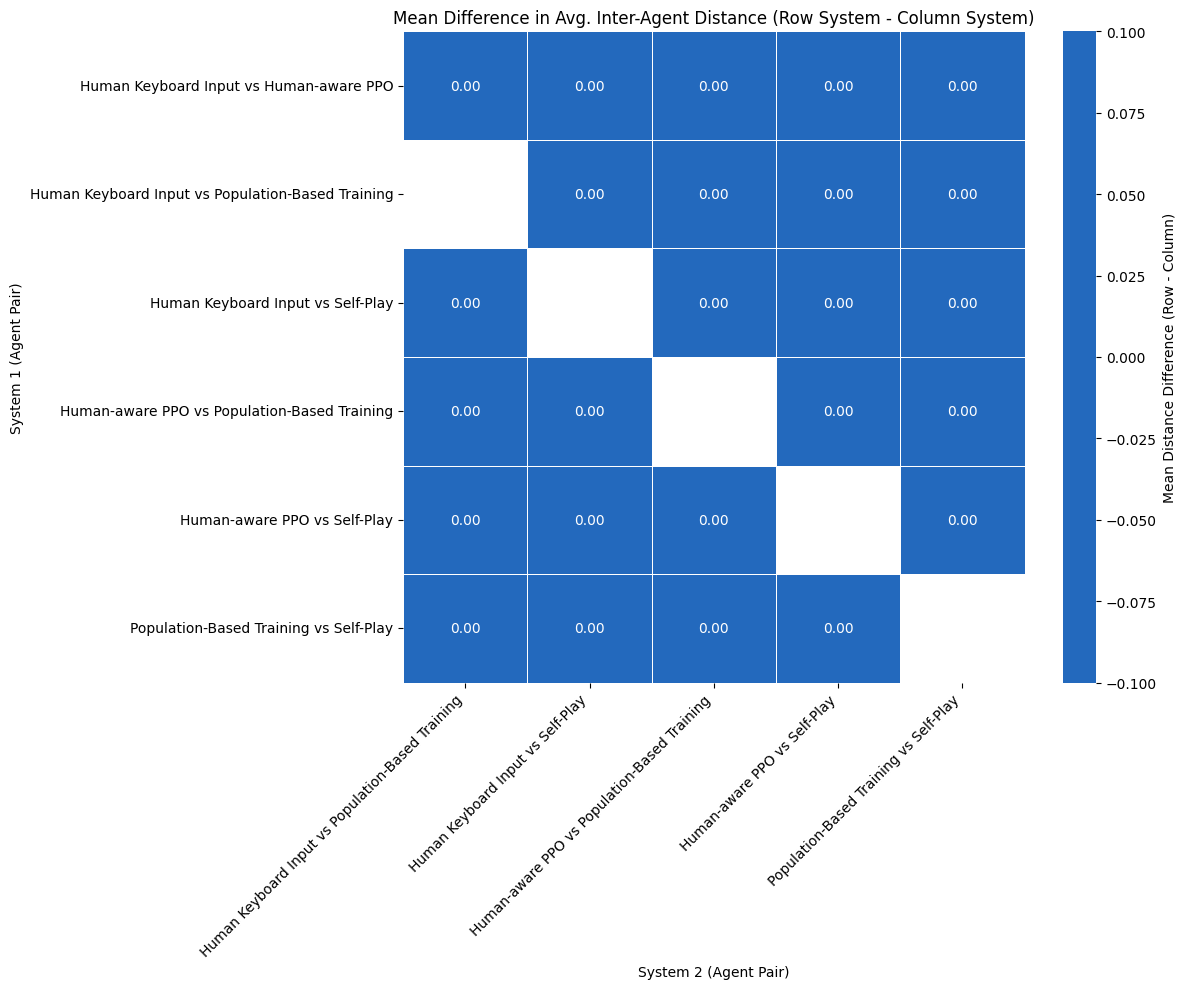

In [12]:
import os
import json
import re
import numpy as np
import itertools
import sys 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

FILENAME_PATTERN = re.compile(
    # Regex to capture agent names, game details, and run number
    r"^(?P<agent1>.*?) vs (?P<agent2>.*?) (?P<gamelendetails>\d+ sec .*?)(?P<run_open_space> \() *(?P<run_digits>\d+)(?P<run_close>\)\.json)$"
)

# --- Debugging Flag ---
# Set to True to print details for the first file processed and exit.
DEBUG_SINGLE_FILE_EXTRACTION = False # <<< SET TO FALSE FOR NORMAL RUN
first_file_processed_for_debug = False # Internal flag for debug logic
# --- End Debugging Flag ---

def _calculate_euclidean_distance(pos1, pos2):
    """Calculates Euclidean distance between two 2D points."""
    # Ensure positions are valid numbers before calculation
    if not (isinstance(pos1[0], (int, float)) and isinstance(pos1[1], (int, float)) and
            isinstance(pos2[0], (int, float)) and isinstance(pos2[1], (int, float))):
        return None 
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def _extract_average_distance_from_file(filepath):
    """
    Loads a JSON trajectory file and calculates the average distance
    between the two players over all timesteps, using the correct JSON structure.
    """
    global first_file_processed_for_debug # Needed only if DEBUG_SINGLE_FILE_EXTRACTION is True

    # --- Optional Detailed Internal Logging Activation ---
    # (Keep commented out unless debugging a specific file again)
    # if DEBUG_SINGLE_FILE_EXTRACTION and not first_file_processed_for_debug:
    #     print(f"\nDEBUG_SINGLE_FILE_EXTRACTION: Processing file:")
    #     print(f"  {filepath}")
    # --- End Optional Detailed Internal Logging Activation ---

    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception as e:
        print(f"  Error reading/parsing {filepath}: {e}")
        return None

    # Access data using the structure: data["ep_observations"][timestep][0]["players"][player_idx]["position"]
    if 'ep_observations' not in data or not isinstance(data['ep_observations'], list) or not data['ep_observations']:
        # if DEBUG_SINGLE_FILE_EXTRACTION and not first_file_processed_for_debug: print(f"  DEBUG: 'ep_observations' key missing, not a list, or empty in {filepath}.")
        return None
    
    distances_in_run = []
    valid_positions_count = 0

    for i, obs_list in enumerate(data['ep_observations']):
        if not obs_list or not isinstance(obs_list, list) or not isinstance(obs_list[0], dict):
            # if DEBUG_SINGLE_FILE_EXTRACTION and not first_file_processed_for_debug and i < 5: print(f"    DEBUG Timestep {i}: Inner observation list invalid.")
            continue
        state = obs_list[0] 
        pos0, pos1 = None, None 
        try:
            players_list = state.get('players')
            if players_list and isinstance(players_list, list) and len(players_list) == 2:
                player_0_data = players_list[0]
                player_1_data = players_list[1]
                if player_0_data and isinstance(player_0_data, dict):
                    pos0 = player_0_data.get('position')
                if player_1_data and isinstance(player_1_data, dict):
                    pos1 = player_1_data.get('position')

                if pos0 and pos1 and isinstance(pos0, list) and len(pos0) == 2 and \
                   isinstance(pos1, list) and len(pos1) == 2:
                    dist = _calculate_euclidean_distance(pos0, pos1)
                    if dist is not None: 
                        distances_in_run.append(dist)
                        valid_positions_count +=1
                        # if DEBUG_SINGLE_FILE_EXTRACTION and not first_file_processed_for_debug and i < 5: print(f"      DEBUG Timestep {i}: Dist: {dist:.2f}")
        except Exception as e:
            # if DEBUG_SINGLE_FILE_EXTRACTION and not first_file_processed_for_debug and i < 5: print(f"    DEBUG Timestep {i}: Error processing state: {e}")
            pass 
            
    # --- Optional Detailed Internal Logging for file summary ---
    # if DEBUG_SINGLE_FILE_EXTRACTION and not first_file_processed_for_debug:
    #     print(f"  DEBUG Summary for {filepath}:")
    #     print(f"    Total timesteps in ep_observations: {len(data['ep_observations'])}")
    #     print(f"    Timesteps with valid positions found: {valid_positions_count}")
    #     mean_val = np.mean(distances_in_run) if distances_in_run else 'N/A'
    #     print(f"    Mean distance for this file: {mean_val if isinstance(mean_val, str) else f'{mean_val:.4f}'}") 
    # --- End Optional Detailed Internal Logging ---

    # --- REMOVED Debugging exit logic ---
    # if DEBUG_SINGLE_FILE_EXTRACTION and not first_file_processed_for_debug:
    #     first_file_processed_for_debug = True 
    #     # ... (print messages) ...
    #     sys.exit() 
    # --- End REMOVED Debugging exit logic ---

    # Return the mean distance if any valid distances were calculated
    return np.mean(distances_in_run) if distances_in_run else None

def get_agent_pair_distances(directory_path, target_agent_pair_tuple): 
    """
    Collects average distances for all runs of a specific agent pair.
    """
    if not isinstance(target_agent_pair_tuple, tuple) or len(target_agent_pair_tuple) != 2:
        raise ValueError("target_agent_pair_tuple must be a tuple of two agent names.")
    if target_agent_pair_tuple[0] > target_agent_pair_tuple[1]:
        raise ValueError("target_agent_pair_tuple must have agent names sorted alphabetically.")

    canonical_target_name = " vs ".join(target_agent_pair_tuple)
    run_distances = {}
    found_any_match_for_this_target_pair = False

    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            match = FILENAME_PATTERN.match(filename)
            if match:
                file_data = match.groupdict()
                agent1_from_filename = file_data['agent1'].strip()
                agent2_from_filename = file_data['agent2'].strip()
                file_pair_canonical_name_from_file = " vs ".join(sorted([agent1_from_filename, agent2_from_filename]))

                if file_pair_canonical_name_from_file == canonical_target_name:
                    found_any_match_for_this_target_pair = True
                    try:
                        run_num = int(file_data['run_digits'])
                        filepath = os.path.join(directory_path, filename)
                        # Call the function to extract distance (no longer exits)
                        avg_dist = _extract_average_distance_from_file(filepath) 
                        if avg_dist is not None:
                            if run_num in run_distances:
                                print(f"  Warning: Duplicate run number {run_num} for pair '{canonical_target_name}'. File: {filename}. Overwriting.")
                            run_distances[run_num] = avg_dist
                    except ValueError:
                        print(f"  Warning: Could not parse run number from filename {filename}")

    # Report summary for the pair after checking all files
    if not run_distances and not found_any_match_for_this_target_pair :
         print(f"  No files found whose agent names form the pair: '{canonical_target_name}'.")
    elif not run_distances and found_any_match_for_this_target_pair:
        print(f"  Files found for pair '{canonical_target_name}', but no valid distance data extracted from them.")
    elif run_distances:
        print(f"  Found {len(run_distances)} runs with valid distance data for '{canonical_target_name}'.")
    return run_distances

def compare_systems_distance_distribution(directory_path, system1_agents_tuple, system2_agents_tuple):
    """
    Compares two systems (agent pairs) based on the distribution of their
    average inter-agent distances. Returns the mean difference or None.
    """
    print(f"\nProcessing System 1: '{' vs '.join(system1_agents_tuple)}'")
    system1_run_distances_map = get_agent_pair_distances(directory_path, system1_agents_tuple)
    print(f"Processing System 2: '{' vs '.join(system2_agents_tuple)}'")
    system2_run_distances_map = get_agent_pair_distances(directory_path, system2_agents_tuple)

    system1_avg_distances = [system1_run_distances_map[k] for k in sorted(system1_run_distances_map.keys())]
    system2_avg_distances = [system2_run_distances_map[k] for k in sorted(system2_run_distances_map.keys())]
    
    s1_name_display = " vs ".join(system1_agents_tuple)
    s2_name_display = " vs ".join(system2_agents_tuple)

    print(f"\n--- Comparison Summary for (S1) '{s1_name_display}' vs (S2) '{s2_name_display}' ---")

    valid_s1_data = bool(system1_avg_distances)
    valid_s2_data = bool(system2_avg_distances)

    mean_diff_result = None # Initialize result

    if not valid_s1_data:
        print(f"No distance data successfully processed for System 1 ({s1_name_display}). Cannot perform full comparison.")
    if not valid_s2_data:
        print(f"No distance data successfully processed for System 2 ({s2_name_display}). Cannot perform full comparison.")
    
    if valid_s1_data and valid_s2_data:
        print(f"System 1 ({s1_name_display}) - Runs: {len(system1_avg_distances)}")
        print(f"  Overall Mean Distance (S1): {np.mean(system1_avg_distances):.2f}")
        print(f"\nSystem 2 ({s2_name_display}) - Runs: {len(system2_avg_distances)}")
        print(f"  Overall Mean Distance (S2): {np.mean(system2_avg_distances):.2f}")

        num_common_runs = min(len(system1_avg_distances), len(system2_avg_distances))
        if num_common_runs == 0:
            print("\nNo common runs with valid data to form a difference distribution.")
        else:
            if len(system1_avg_distances) != len(system2_avg_distances):
                 print(f"\nWarning: Systems have different numbers of runs ({len(system1_avg_distances)} vs {len(system2_avg_distances)}). Difference based on first {num_common_runs} runs.")
            
            difference_distribution = [system1_avg_distances[i] - system2_avg_distances[i] for i in range(num_common_runs)]
            
            print(f"\n--- Distance Difference Distribution (S1_AvgDist - S2_AvgDist) ---")
            print(f"Number of difference data points: {len(difference_distribution)}")
            if difference_distribution:
                mean_diff_result = np.mean(difference_distribution)
                print(f"  Mean of Differences:   {mean_diff_result:.2f}")
            else:
                print("  No data points in the difference distribution.")
                
    return mean_diff_result

def plot_comparison_heatmap(results_matrix, output_filename="distance_comparison_heatmap.png"):
    """Generates and saves a heatmap from the comparison results matrix."""
    
    if not results_matrix:
        print("No comparison results to plot.")
        return

    # Filter out entries where the inner dictionary might be empty if a system failed entirely
    filtered_results = {k: v for k, v in results_matrix.items() if v}
    if not filtered_results:
        print("No valid comparison results to plot after filtering.")
        return

    df = pd.DataFrame.from_dict(filtered_results, orient='index')
    
    # Ensure all expected pairs are present as index and columns, fill missing with NaN
    all_pairs_index = pd.MultiIndex.from_tuples(sorted(results_matrix.keys()))
    all_pairs_columns = pd.MultiIndex.from_tuples(sorted(list(all_comparison_results.values())[0].keys())) # Get columns from first valid entry
    
    df = df.reindex(index=all_pairs_index, columns=all_pairs_columns)

    # Create string labels for the heatmap axes
    index_labels = [" vs ".join(pair) for pair in df.index]
    column_labels = [" vs ".join(pair) for pair in df.columns]
    df.index = index_labels
    df.columns = column_labels

    plt.figure(figsize=(12, 10)) 
    sns.heatmap(df, annot=True, fmt=".2f", cmap="vlag", center=0, linewidths=.5, cbar_kws={'label': 'Mean Distance Difference (Row - Column)'}) 
    
    plt.title('Mean Difference in Avg. Inter-Agent Distance (Row System - Column System)')
    plt.xlabel('System 2 (Agent Pair)')
    plt.ylabel('System 1 (Agent Pair)')
    plt.xticks(rotation=45, ha='right') 
    plt.yticks(rotation=0)
    plt.tight_layout() 

    try:
        plt.savefig(output_filename, dpi=300)
        print(f"\nHeatmap saved successfully to: {output_filename}")
    except Exception as e:
        print(f"\nError saving heatmap: {e}")

if __name__ == "__main__":
    ALL_AGENT_NAMES = sorted([
        "Human-aware PPO",
        "Population-Based Training",
        "Self-Play",
        "Human Keyboard Input"
    ])
    
    raw_agent_pairs = list(itertools.combinations(ALL_AGENT_NAMES, 2))
    valid_agent_pairs_tuples = sorted([tuple(sorted(pair)) for pair in raw_agent_pairs])
    
    print(f"Found {len(valid_agent_pairs_tuples)} unique agent pairs for analysis:")
    for i, pair_tuple in enumerate(valid_agent_pairs_tuples):
        print(f"  {i+1}. {pair_tuple[0]} vs {pair_tuple[1]}")

    relative_path_parts = ["game_trajectories", "Cramped Room"]
    
    user_defined_absolute_path = None
    if 'directory_to_process' in locals() and isinstance(locals()['directory_to_process'], str):
        if os.path.isabs(locals()['directory_to_process']):
             user_defined_absolute_path = locals()['directory_to_process']

    if user_defined_absolute_path:
        final_directory_to_process = user_defined_absolute_path
        print(f"\nUsing user-defined absolute path: {final_directory_to_process}")
    else:
        try:
            script_location_dir = os.path.dirname(os.path.realpath(__file__))
        except NameError: 
            script_location_dir = os.getcwd()
            print(f"\nWarning: __file__ not defined. Using current working directory as script's base: {script_location_dir}")
        
        final_directory_to_process = os.path.join(script_location_dir, *relative_path_parts)
        print(f"\nScript base location: {script_location_dir}")
        print(f"Target directory for processing: {final_directory_to_process}")

    if not os.path.isdir(final_directory_to_process):
        print(f"\nError: Target directory '{final_directory_to_process}' is not valid or not configured.")
    else:
        print("\n--- Starting All-Pairs Distance Comparisons ---")
        comparison_count = 0
        # Use tuples directly as keys since they are hashable and sorted
        all_comparison_results = {pair: {} for pair in valid_agent_pairs_tuples} 

        for i in range(len(valid_agent_pairs_tuples)):
            system1_agents = valid_agent_pairs_tuples[i] # e.g., ('Human Keyboard Input', 'Human-aware PPO')
            
            for j in range(len(valid_agent_pairs_tuples)):
                if i == j: continue 
                
                system2_agents = valid_agent_pairs_tuples[j] # e.g., ('Human Keyboard Input', 'Population-Based Training')

                print(f"\n\n{'='*70}")
                print(f"COMPARING (S1) {system1_agents[0]} vs {system1_agents[1]}  AGAINST  (S2) {system2_agents[0]} vs {system2_agents[1]}")
                print(f"{'='*70}")
                
                # Call comparison function (no longer needs the repr map)
                mean_diff = compare_systems_distance_distribution(
                    final_directory_to_process,
                    system1_agents, 
                    system2_agents
                )
                
                # Store the result using the tuple as key
                all_comparison_results[system1_agents][system2_agents] = mean_diff
                comparison_count += 1
        
        print(f"\n\n--- Finished all {comparison_count} comparisons. ---")

        plot_comparison_heatmap(all_comparison_results)

